# 10.recurrent neural networks

## Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
from IPython.display import HTML

# Common imports
import numpy as np
import os
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import matplotlib.image as mpimg
def plot_external(img):
    img_name = os.path.join(".", "images",img)
    plots = mpimg.imread(img_name)
    plt.axis("off")
    plt.imshow(plots)    
    plt.show()
    
def plot_external2(imgpath):    
    plots = mpimg.imread(imgpath)
    plt.axis("off")
    plt.imshow(plots)    
    plt.show()  

# batch function
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        
from tensorflow.keras.backend import clear_session

def makedir(path):
    if not os.path.isdir(path):
        os.makedirs(path)
        print("directory created!!")
    else:
        print("directory exist!!")

완전 연결 네트워크나 컨브넷처럼 지금까지 본 모든 신경망의 특징은 메모리가 없다는 것입니다. 네트워크에 주입되는 입력인 개별적으로 처리되며 입력 간에 유지되는 상태가 없습니다. 이런 네트워크로 시퀀스나 시계열 데이터 포인트를 처리하려면 네트워크에 전체 시퀀스를 주입해야 합니다. 즉 전체 시퀀스를 하나의 데이터 포인트로 변환해야 합니다. 예를 들어 IMDB 문제에서 영화 리뷰 하나를 큰 벡터 하나로 변환하여 처리했습니다. 이런 네트워크를 **피드포워드 네트워크**라고 합니다.  

이와 반대로 사람이 문장을 읽는 것처럼 이전에 나온 것을 기억하면서 단어별로 또는 한눈에 들어오는 만큼씩 처리할 수 있습니다. 이는 문장에 있는 의미를 자연스럽게 표현되도록 도와줍니다. 생물학적 지능은 정보 처리를 위한 내부 모델을 유지하면서 점진적으로 정보를 처리합니다. 이 모델은 과거 정보를 사용하여 구축되며 새롭게 얻은 정보를 계쏙 업데이트합니다.  

비록 극단적으로 단순화시켠 버전이지만 순환 신경망(Recurrent Neural Network, RNN)은 같은 원리를 적용한 것입니다. 시퀀스의 원소를 순회하면서 지금까지 처리한 정보를 상태(state)에 저장합니다. 사실 RNN은 내부에 루프(loop)를 가진 신경망의 한 종류입니다(아래 그림). RNN의 상태는 2개의 다른 시퀀스(2개의 다른 IMDB 리뷰)를 처리하는 사이에 재설정됩니다. 하나의 시퀀스가 여전히 하나의 데이터 포인트로 간주됩니다. 즉 네트워크에 하나의 입력을 주입한다고 가정합니다. 이 데이터 포인트가 한 번에 처리되지 않는다는 것이 다릅니다. 그 대신 네트워크는 시퀀스의 원소를 차례대로 방문합니다. 

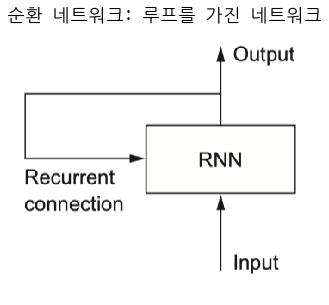

In [3]:
plt.figure(figsize=(10, 5))
plt.title("순환 네트워크: 루프를 가진 네트워크", fontsize=18)
plot_external2("./images/ch10/1.png")
plt.show()

루프와 상태에 대한 개념을 명확히 하기 위해 넘파이로 간단한 RNN 정방향 계산을 구현해보겠습니다. 이 RNN은 크기가 (timesteps, input_features)인 2D 텐서로 인코딩된 벡터의 시퀀스를 입력받습니다. 이 시퀀스는 타임스텝을 따라서 반복됩니다. 각 타입스텝 t에서 현재 상태와 ((input_features,) 크기의)입력을 연결하여 출력을 계산합니다. 그 다음 이 출력을 다음 스텝의 상태로 설정합니다. 첫 번째 타임스텝에서는 이전 출력이 정의되지 않으므로 현재 상태가 없습니다. 이 때는 네트워크의 초기 상태(initial state)인 0벡터로 상태를 초기화합니다.  

의사코드(pseudocode)로 표현하면 RNN은 다음과 같습니다.

> 의사코드(pseudocode)로 표현한 RNN

```python
state_t = 0 ## timestep t의 상태입니다.
for input_t in input_sequence: # 시퀀스의 원소를 반복합니다.
    output_t = f(input_t, state_t)
    state_t = output_t # 출력은 다음 반복을 위한 상태가 됩니다.
```

f함수는 입력과 상태를 출력으로 변환합니다. 이를 2개의 행렬 W와 그리고 U 그리고 변향 벡터를 사용하는 변환으로 바꿀 수 있습니다. 피드포워드 네트워크의 완전 연결층에서 수행되는 변환과 비슷합니다.

```python
state_t = 0 ## timestep t의 상태입니다.
for input_t in input_sequence: # 시퀀스의 원소를 반복합니다.
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t # 출력은 다음 반복을 위한 상태가 됩니다.
```

In [4]:
import numpy as np

In [5]:
timesteps = 100 # 입력시퀀스에 있는 타임스텝의 수
input_features = 32 # 입력 특성의 차원
output_features = 64 # 출력 특성의 차원

In [7]:
inputs = np.random.random((timesteps, input_features)) # 입력 데이터
state_t = np.zeros((output_features, )) # 초기상태: 모두 0인 벡터

In [10]:
# 랜덤한 가중치 행렬을 만듬
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

In [11]:
successive_outputs = []
for input_t in inputs: # input_t: 크기가 (input_features,)인 벡터
    # 입력과 현재상태(이전 출력을)연결하여 현재 출력을 얻음
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t) # 이 출력을 리스트에 저장
    
    state_t = output_t # 다음 타임스텝을 위해 네트워크의 상태를 업데이트

# 최종 출력은 크기가 (timesteps, output_features)인 2D 텐서
final_output_sequence = np.stack(successive_outputs, axis=0)

요약하면 RNN은 반복할 때 **이전에 계산한 정보를 재사용하는 for 루프**에 지나지 않습니다. 이 예는 가장 간단한 RNN의 형태입니다. RNN은 스텝(step)함수에 의해 특화됩니다. 이 예에서는 아래그림과 같습니다.

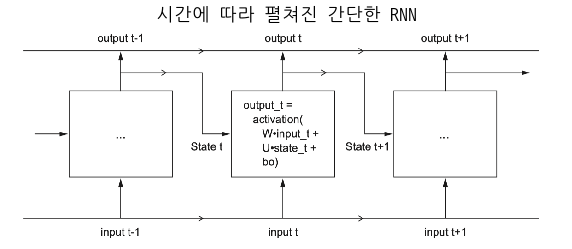

In [14]:
plt.figure(figsize=(10, 5))
plt.title("시간에 따라 펼쳐진 간단한 RNN", fontsize=18)
plot_external2("./images/ch10/2.png")
plt.show()

이 예에서 최종 출력은 (timesteps, output_features)크기의 2D 텐서입니다. 각 타임스텝은 시간 t에서의 출력을 나타냅니다. 출력 텐서의 각 타임스텝 t에는 입력 시퀀스에 있는 타임스텝 0에서 t까지 전체 과거에 대한 정보를 담고 있습니다. 이런 이유 때문에 많은 경우 전체 출력 시퀀스가 필요하지 않습니다. 전체 시퀀스에 대한 정보를 이미 담고 있으므로 마지막 출력(류프의 마지막 output_t)만 있으면 됩니다.

<br>

## 10.1 A recurrent layer in Keras

넘파이로 간단하게 구현한 과정이 실제 케라스의 SimpleRNN 층에 해당합니다:

In [15]:
from tensorflow.keras.layers import SimpleRNN

SimpleRNN이 한 가지 다른 점은 넘파이 예제처럼 하나의 시퀀스가 아니라 다른 케라스 층과 마찬가지로 시퀀스 배치를 처리한다는 것입니다. 즉, (timesteps, input_features) 크기가 아니라 (batch_size, timesteps, input_features) 크기의 입력을 받습니다.

케라스에 있는 모든 순환 층과 동일하게 SimpleRNN은 두 가지 모드로 실행할 수 있습니다. 각 타임스텝의 출력을 모은 전체 시퀀스를 반환하거나(크기가 (batch_size, timesteps, output_features)인 3D 텐서), 입력 시퀀스에 대한 마지막 출력만 반환할 수 있습니다(크기가 (batch_size, output_features)인 2D 텐서). 이 모드는 객체를 생성할 때 return_sequences 매개변수로 선택할 수 있습니다. SimepleRNN의 입력 특성 크기는 Embedding 층의 출력 특성 크기가 되므로 특성과 출력 특성의 크기가 모두 32입니다. 전체 가중치 파라미터 수는 (32, 32)크기의 W, U와 (32,)크기의 b를 더하여 2,080이 됩니다.

In [18]:
from tensorflow.keras.layers import Embedding, SimpleRNN

clear_session()
model = tf.keras.Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


<br>

다음 예는 전체 상태 시퀀스를 반환합니다. 층의 이름은 클래스 이름에서 단어 사이에 언더바를 추가하고 소문자로 바꾸어 사용합니다(snake case). 이름 뒤에 붙는 숫자는 클래스별로 1씩 증가됩니다. 별도의 이름을 주려면 SimpleRNN(32, name="myname")처럼 `name` 매개변수를 사용합니다.

In [20]:
from tensorflow.keras.layers import Embedding, SimpleRNN

clear_session()
model = tf.keras.Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


<br>

네트워크의 표현력을 증가시키기 위해 여러 개의 순환 층을 차례대로 쌓는 것이 유용할 때가 있습니다. 이런 설정에서는 중간 층들이 전체 출력 시퀀스를 반환하도록 설정해야 합니다:

In [21]:
from tensorflow.keras.layers import Embedding, SimpleRNN

clear_session()
model = tf.keras.Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # 맨 위 층만 마지막 출력을 반환합니다.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


<br>

이제 IMDB 영화 리뷰 분류 문제에 적용해 보겠습니다.

In [22]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # 특성으로 사용할 단어의 수
maxlen = 500  # 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)
batch_size = 32

print('데이터 로딩...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print('{} 훈련 시퀀스'.format(len(input_train)))
print('{} 테스트 시퀀스'.format(len(input_test)))

print('\n시퀀스 패딩 (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train 크기: {}'.format(input_train.shape))
print('input_test 크기:'.format(input_test.shape))

데이터 로딩...
25000 훈련 시퀀스
25000 테스트 시퀀스

시퀀스 패딩 (samples x time)
input_train 크기: (25000, 500)
input_test 크기:


<br>

Embedding 층과 SimpleRNN 층을 사용해 간단한 순환 네트워크를 훈련시켜 보겠습니다:

In [25]:
from tensorflow.keras.layers import Dense

model = tf.keras.Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

In [26]:
from tensorflow.keras import optimizers, losses, metrics

model.compile(optimizer=optimizers.Adam(lr=1e-4), 
              loss=losses.binary_crossentropy, 
              metrics=[metrics.binary_accuracy])

W0805 17:40:49.909375 140134840395584 deprecation.py:323] From /opt/conda/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [27]:
class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs):
        self.epochs = epochs
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch                
              
    def on_train_batch_end(self, batch, logs=None):        
        print('\repoch: {}, loss {:.5f}, acc {:.5f}'.format(self.epoch+1, 
                                                            logs['loss'], 
                                                            logs["binary_accuracy"]), end=" ")
              
    def on_epoch_end(self, epoch, logs=None):        
        if epoch == 0:
            print("\nhistory key: {}".format(list(logs.keys())))
            
        self.n_batch_steps = self.epochs // 5
        if (epoch+1) % self.n_batch_steps == 0 or epoch+1 == self.epochs:
            print("\rEpoch {}/{}".format(epoch+1, self.epochs), end=" ")
            print("loss: {:.5f}".format(logs["loss"]), end=" ")
            print("acc: {:.5f}".format(logs["binary_accuracy"]), end=" ")
            print("val_loss: {:.5f}".format(logs["val_loss"]), end=" ")
            print("val_acc: {:.5f}".format(logs["val_binary_accuracy"]))

In [28]:
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2,
                    verbose=0,
                    callbacks=[LossAndErrorPrintingCallback(epochs=10)])

epoch: 1, loss 0.69467, acc 0.54840 
history key: ['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy']
Epoch 2/10 loss: 0.58715 acc: 0.71320 val_loss: 0.53834 val_acc: 0.75700
Epoch 4/10 loss: 0.42675 acc: 0.82880 val_loss: 0.44610 val_acc: 0.81240
Epoch 6/10 loss: 0.40444 acc: 0.84350 val_loss: 0.41393 val_acc: 0.83000
Epoch 8/10 loss: 0.30358 acc: 0.89405 val_loss: 0.37684 val_acc: 0.84580
Epoch 10/10 loss: 0.24264 acc: 0.92315 val_loss: 0.36273 val_acc: 0.85520


In [29]:
makedir("./models/ch10_RNN")
model.save("models/ch10_RNN/simpleRNN.h5")

directory created!!


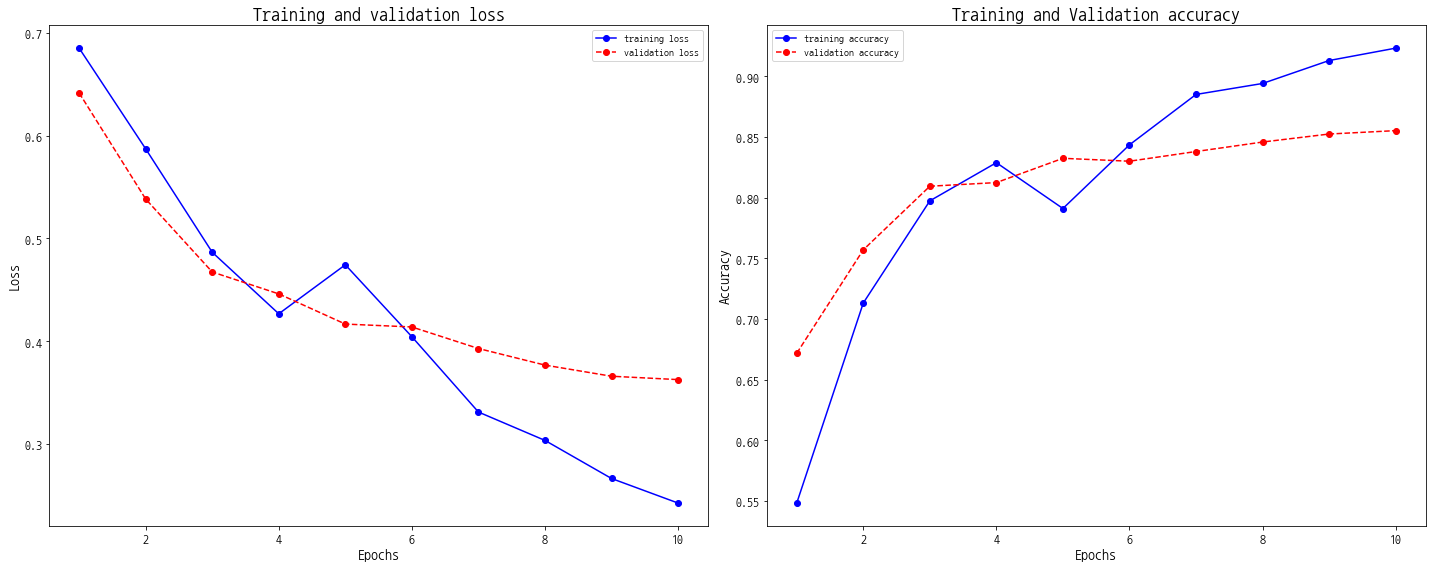

In [30]:
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

acc = history_dict["binary_accuracy"]
val_acc = history_dict["val_binary_accuracy"]

epochs = range(1, len(loss)+1)

plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.plot(epochs, loss, "bo-", label="training loss")
plt.plot(epochs, val_loss, "ro--", markerfacecolor="red", markeredgecolor="red", label="validation loss")
plt.title("Training and validation loss", fontsize=18)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, "bo-", label="training accuracy")
plt.plot(epochs, val_acc, "ro--", markerfacecolor="red", markeredgecolor="red", label="validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation accuracy", fontsize=18)
plt.legend()

plt.tight_layout()
plt.show()

이전에 데이터셋을 사용한 첫 번째 모델에서 얻은 테스트 정확도는 87%였습니다. 간단한 순환 네트워크는 이 기준 모델보다 성능이 높지 않습니다(85% 정도의 검증 정확도를 얻었습니다). 이런 원인은 전체 시퀀스가 아니라 처음 500개의 단어만 입력에 사용했기 때문입니다. 이 RNN은 기준 모델보다 얻은 정보가 적습니다. 다른 이유는 SimpleRNN이 텍스트와 같이 긴 시퀀스를 처리하는데 적합하지 않기 때문입니다. 더 잘 작동하는 다른 순환 층이 있습니다.